In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sea

In [2]:
def MinMaxDF(df):
    cols = df.columns
    
    for col in cols:
        currMin = list(df[col].sort_values())[0]
        currMax = list(df[col].sort_values())[-1]
        
        MinMax = lambda x,currMin, currMax: (x-currMin)/(currMax-currMin)
        
        df[col] =df[col].apply(MinMax, args=(currMin, currMax))
    return df

# Reporte de clasificacion de datos de INEGI sobre Turismo
- En este reporte se explica el uso de Kmeans para la clasificación de datos de turismo
- Pretendemos clasificar los comportamientos de los meses dependiendo de las variables como son el gasto de cada mes, el metodo que mas se usa para viajar en cada mes, etc.
- Para lograr el objetivo se tuvo que limpiar y transformar los datos antes de aplicarlos en el algortimo de K-Means


- Jack Robles y Jorge Erosa

## Importar Datos Inegi en formato CSV

In [3]:
df1 = pd.read_csv("tr_eti_18_20.csv")
df2 = pd.read_csv("tr_evf_18_20.csv")

## Inspección de los contenidos de ambos datos

In [4]:
df1.head(2)

,PROD_EST,ANIO,MES,TIPO,TIPO_DE_TRANSPORTE,CATEGORIA,VARIABLE,VALOR,UNIDAD_DE_MEDIDA,ESTATUS
0,Encuesta de Turismo de Internación (ETI),2018,Agosto,Ingresos,Aéreo,Turistas de internación,Gasto total,1358750907,Dólares,Cifras revisadas
1,Encuesta de Turismo de Internación (ETI),2018,Agosto,Ingresos,Terrestre,Turistas de internación,Gasto total,105686094,Dólares,Cifras revisadas


In [5]:
df2.head(2)

,PROD_EST,ANIO,MES,TIPO,TIPO_DE_TRANSPORTE,CATEGORIA,VARIABLE,VALOR,UNIDAD_DE_MEDIDA,ESTATUS
0,Encuesta de Viajeros Fronterizos (EVF),2018,Agosto,Ingresos,Peatones,Turistas fronterizos,Gasto total,14093185,Dólares,Cifras revisadas
1,Encuesta de Viajeros Fronterizos (EVF),2018,Agosto,Ingresos,En automóviles,Turistas fronterizos,Gasto total,90268996,Dólares,Cifras revisadas


## Limpieza de Datos

#### Eliminando datos que no son de interés para el análisis

In [6]:
df1 = df1.drop(columns = ["ESTATUS","PROD_EST"])
df2 = df2.drop(columns = ["ESTATUS","PROD_EST"])

In [7]:
df1.head(2)

,ANIO,MES,TIPO,TIPO_DE_TRANSPORTE,CATEGORIA,VARIABLE,VALOR,UNIDAD_DE_MEDIDA
0,2018,Agosto,Ingresos,Aéreo,Turistas de internación,Gasto total,1358750907,Dólares
1,2018,Agosto,Ingresos,Terrestre,Turistas de internación,Gasto total,105686094,Dólares


#### Separando datos de ingresos y egresos
- Esto sirve para poder tener un mayor control en nuestro analisis y clasicicación de los datos obtenidos
- Se separó los datos en Ingreso y egresos, Gasto monetario y numero de visitantes

In [8]:
df1In = df1.loc[df1.TIPO == "Ingresos"]
df1In = df1In.loc[df1In.VARIABLE == "Gasto total"]
df1En = df1.loc[df1.TIPO == "Egresos"]
df1En = df1En.loc[df1En.VARIABLE == "Gasto total"]


df2In = df2.loc[df2.TIPO == "Egresos"]
df2In = df2In.loc[df2In.VARIABLE == "Gasto total"]
df2En = df2.loc[df2.TIPO == "Egresos"]
df2En = df2En.loc[df2En.VARIABLE == "Gasto total"]

#### Eliminando variables 
- Como nuestro objectivo es clasificar los meses en bases a las tendendencias de otras variables, el año no es de interés para el análisis.

- La unidad de medida solo es útil para dar contexto a los humanos, sin emabrgo para la clasificacion en base a clusters usando el algoritmo de K-Means, el tipo de unidad no es de utilidad.

- Ya se sabe que todos los valores de "VALOR" son de gasto total, por lo que la columna "VARIABLE" queda sin utilidad

In [9]:
df1In=df1In.drop(columns = ["ANIO","TIPO","UNIDAD_DE_MEDIDA","VARIABLE"])
df1En=df1En.drop(columns = ["ANIO","TIPO","UNIDAD_DE_MEDIDA","VARIABLE"])
    
df2In=df2In.drop(columns = ["ANIO","TIPO","UNIDAD_DE_MEDIDA","VARIABLE"])
df2En=df2En.drop(columns = ["ANIO","TIPO","UNIDAD_DE_MEDIDA","VARIABLE"])

## Uniendo DataSets
- Se crearon 2 datasets 
- Uno conteninedo ingresos totales de los turistas
- El segundo conteniendo ingresos totales de Turistas por mes

In [10]:
dfIn = pd.concat([df1In, df2In],ignore_index=True,sort=False)
dfEn = pd.concat([df1En, df2En],ignore_index=True,sort=False)

#### Previsualizar DataFrame

In [11]:
dfIn

,MES,TIPO_DE_TRANSPORTE,CATEGORIA,VALOR
0,Agosto,Aéreo,Turistas de internación,1358750907
1,Agosto,Terrestre,Turistas de internación,105686094
2,Agosto,Cruceros,Excursionistas en cruceros,35649178
3,Septiembre,Aéreo,Turistas de internación,1080454557
4,Septiembre,Terrestre,Turistas de internación,80236790
...,...,...,...,...
177,Agosto,En automóviles,Excursionistas fronterizos,59650176
178,Septiembre,Peatones,Turistas fronterizos,3023018
179,Septiembre,En automóviles,Turistas fronterizos,9436896
180,Septiembre,Peatones,Excursionistas fronterizos,16049420


#### Obtener valores únicos de los valores de las columnas no númericas

- La razón de esta acción, es que para usar K-Means, los valores de las columnas deben ser numericas
- Por lo que se crea una ID única a cada valor único de esas columnas

In [12]:
mesesI = list(dfIn.MES.unique())
transporteI = list(dfIn.TIPO_DE_TRANSPORTE.unique())
catI = list(dfIn.CATEGORIA.unique())

print(mesesI)
print(transporteI)
print(catI)

['Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio']
['Aéreo', 'Terrestre', 'Cruceros', 'Peatones', 'En automóviles']
['Turistas de internación', 'Excursionistas en cruceros', 'Turistas fronterizos', 'Excursionistas fronterizos']


In [13]:
dfIn.MES = dfIn.MES.apply(lambda x: mesesI.index(x)+1)
dfIn.TIPO_DE_TRANSPORTE = dfIn.TIPO_DE_TRANSPORTE.apply(lambda x: transporteI.index(x)+1)
dfIn.CATEGORIA = dfIn.CATEGORIA.apply(lambda x: catI.index(x)+1)

#### DataFrame transformado

In [14]:
dfIn

,MES,TIPO_DE_TRANSPORTE,CATEGORIA,VALOR
0,1,1,1,1358750907
1,1,2,1,105686094
2,1,3,2,35649178
3,2,1,1,1080454557
4,2,2,1,80236790
...,...,...,...,...
177,1,5,4,59650176
178,2,4,3,3023018
179,2,5,3,9436896
180,2,4,4,16049420


In [15]:
dfInMM = MinMaxDF(dfIn)

In [16]:
dfInMM

,MES,TIPO_DE_TRANSPORTE,CATEGORIA,VALOR
0,0.000000,0.00,0.000000,0.650838
1,0.000000,0.25,0.000000,0.050623
2,0.000000,0.50,0.333333,0.017076
3,0.090909,0.00,0.000000,0.517535
4,0.090909,0.25,0.000000,0.038433
...,...,...,...,...
177,0.000000,1.00,1.000000,0.028572
178,0.090909,0.75,0.666667,0.001448
179,0.090909,1.00,0.666667,0.004520
180,0.090909,0.75,1.000000,0.007688


#### Calculado los centroides usando una función de scikit learn de kmeans

In [17]:
#Kmeans
features = list(dfInMM.columns)
data = dfIn[features]


KM = KMeans(n_clusters = 4,precompute_distances="auto")

y = KM.fit_predict(dfInMM)
print(len(y)) #NUMERO DE OBSERVACIONES
y#Clusters 

182


array([3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3,
       0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0,
       0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

In [18]:
dfIn["Cluster"] = y

# El DataSet Transformado
- La variable cluster indica a que cluster esa observación pertenece.
- En total se formaron 3 centroides y por lo tanto 3 clusters diferents de observaciones

In [19]:
dfIn.head(50)

,MES,TIPO_DE_TRANSPORTE,CATEGORIA,VALOR,Cluster
0,0.000000,0.00,0.000000,0.650838,3
1,0.000000,0.25,0.000000,0.050623,0
2,0.000000,0.50,0.333333,0.017076,0
3,0.090909,0.00,0.000000,0.517535,3
4,0.090909,0.25,0.000000,0.038433,0
5,0.090909,0.50,0.333333,0.014889,0
6,0.181818,0.00,0.000000,0.604086,3
7,0.181818,0.25,0.000000,0.035503,0
8,0.181818,0.50,0.333333,0.020648,0
9,0.272727,0.00,0.000000,0.686940,3


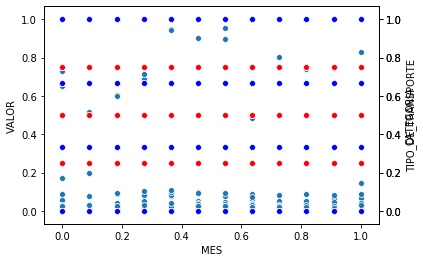

In [20]:
fig,ax = plt.subplots()

sea.scatterplot(data = dfInMM, x = "MES", y = "VALOR", ax=ax)


ax2 = ax.twinx()
sea.scatterplot(data = dfInMM, x = "MES", y = "TIPO_DE_TRANSPORTE", ax = ax2, color = "r")

ax3 = ax.twinx()
sea.scatterplot(data = dfInMM, x = "MES", y = "CATEGORIA", ax = ax3, color = "b")

plt.show()

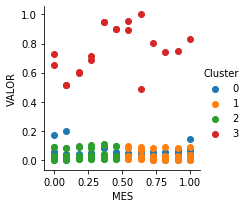

In [21]:
#Grafica de los valores por MES, respecto al gasto monetario
a = sea.FacetGrid(dfIn, hue = 'Cluster')
a = a.map(plt.scatter, 'MES', "VALOR")
a = a.add_legend()



In [ ]:
dfclus1 = dfIn.loc[]